In [1]:
# Advanced models – OS fingerprinting on flows_ml_ready.csv

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# ---------------------------
# 1. Load ML-ready data
# ---------------------------

DATA_PATH = "flows_ml_ready.csv"   # adjust path if needed

df = pd.read_csv(DATA_PATH, sep=";")
print("Raw shape:", df.shape)
print(df.head())


Raw shape: (109663, 52)
  UA OS family  BYTES A  PACKETS A TCP flags A  TCP SYN Size  TCP Win Size  \
0        Other      696          6    ---AP-SF          60.0       64240.0   
1        Other      489          4    ---AP-SF          60.0       29200.0   
2        Other      587          5    ---AP-SF          60.0       64240.0   
3      Windows     1825         12    ---AP-SF          52.0       64240.0   
4        Other      605          5    ---AP-SF          60.0       64240.0   

   TCP SYN TTL  IP ToS  IPv4DontFragmentforward  maximumTTLforward  ...  \
0           64       0                        1                 57  ...   
1           64       0                        1                 58  ...   
2           64       0                        1                 57  ...   
3          128      48                        1                119  ...   
4           64       0                        1                 57  ...   

   TLS_CIPHER_SUITE  TLS_ALPN  TLS_SNI_LENGTH  \
0      

In [2]:
# ---------------------------
# 2. Target + features
# ---------------------------

label_col = "UA OS family"

# Sanity check
print("OS families before merging:")
print(df[label_col].value_counts())

# Use all columns except label as initial features
X_full = df.drop(columns=[label_col])
y = df[label_col]

# Keep only numeric features for now (simplifies SVM/MLP)
X = X_full.select_dtypes(include=[np.number])

print("\nNumeric feature columns used:", len(X.columns))
print(X.columns.tolist())

# ---------------------------
# 3. Merge small classes
# ---------------------------
# Example: merge classes with < N samples into "Other"
min_samples_per_class = 50
class_counts = y.value_counts()
small_classes = class_counts[class_counts < min_samples_per_class].index

print("\nClasses with < {} samples:".format(min_samples_per_class))
print(list(small_classes))

y_merged = y.replace(small_classes, "Other")

print("\nClass counts after merging:")
print(y_merged.value_counts())

# ---------------------------
# 4. Encode labels
# ---------------------------

le = LabelEncoder()
y_encoded = le.fit_transform(y_merged)

print("\nEncoded classes:", list(le.classes_))

# ---------------------------
# 5. Train/test split
# ---------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42,
)

print("\nTrain shape:", X_train.shape, " Test shape:", X_test.shape)

# ---------------------------
# 6. Impute NaNs + scale (for SVM/MLP)
# ---------------------------

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

print("NaNs after imputation (train):", np.isnan(X_train_scaled).sum())
print("NaNs after imputation (test):", np.isnan(X_test_scaled).sum())


OS families before merging:
UA OS family
Other      42528
Windows    40349
iOS        14164
Android    10290
Linux       2332
Name: count, dtype: int64

Numeric feature columns used: 43
['BYTES A', 'PACKETS A', 'TCP SYN Size', 'TCP Win Size', 'TCP SYN TTL', 'IP ToS', 'IPv4DontFragmentforward', 'maximumTTLforward', 'tcpTimestampFirstPacketforward', 'tcpOptionWindowScaleforward', 'tcpOptionSelectiveAckPermittedforward', 'tcpOptionMaximumSegmentSizeforward', 'tcpOptionNoOperationforward', 'packetTotalCountforward', 'packetTotalCountbackward', 'flowDirection', 'flowEndReason', 'NPM_CLIENT_NETWORK_TIME', 'NPM_SERVER_NETWORK_TIME', 'NPM_SERVER_RESPONSE_TIME', 'NPM_ROUND_TRIP_TIME', 'NPM_RESPONSE_TIMEOUTS_A', 'NPM_RESPONSE_TIMEOUTS_B', 'NPM_TCP_RETRANSMISSION_A', 'NPM_TCP_RETRANSMISSION_B', 'NPM_TCP_OUT_OF_ORDER_A', 'NPM_TCP_OUT_OF_ORDER_B', 'NPM_JITTER_DEV_A', 'NPM_JITTER_AVG_A', 'NPM_JITTER_DEV_B', 'NPM_JITTER_AVG_B', 'NPM_DELAY_AVG_A', 'NPM_DELAY_AVG_B', 'NPM_DELAY_HISTOGRAM_1_A', 'NPM_DEL

In [3]:
# ---------------------------
# 7. Evaluation helper
# ---------------------------

def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    print(f"\n===== {name} =====")
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    print(f"Train accuracy: {accuracy_score(y_tr, y_tr_pred):.4f}")
    print(f"Test  accuracy: {accuracy_score(y_te, y_te_pred):.4f}")
    print("\nClassification report (test):")
    print(classification_report(y_te, y_te_pred, target_names=le.classes_))


In [4]:
# ---------------------------
# 7. Evaluation helper
# ---------------------------

def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    print(f"\n===== {name} =====")
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    print(f"Train accuracy: {accuracy_score(y_tr, y_tr_pred):.4f}")
    print(f"Test  accuracy: {accuracy_score(y_te, y_te_pred):.4f}")
    print("\nClassification report (test):")
    print(classification_report(y_te, y_te_pred, target_names=le.classes_))


In [6]:
# ---------------------------
# XGBoost model
# ---------------------------

xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

xgb_model.fit(X_train_imp, y_train)  # use imputed numeric features (no scaling needed)

evaluate_model(xgb_model, X_train_imp, y_train, X_test_imp, y_test, name="XGBoost")



===== XGBoost =====
Train accuracy: 1.0000
Test  accuracy: 0.9822

Classification report (test):
              precision    recall  f1-score   support

     Android       0.97      0.99      0.98      2058
       Linux       0.94      0.83      0.88       466
       Other       0.99      0.99      0.99      8506
     Windows       0.98      0.99      0.98      8070
         iOS       0.98      0.96      0.97      2833

    accuracy                           0.98     21933
   macro avg       0.97      0.95      0.96     21933
weighted avg       0.98      0.98      0.98     21933



In [7]:
# ---------------------------
# LightGBM model
# ---------------------------

lgbm_model = LGBMClassifier(
    n_estimators=400,
    num_leaves=64,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",
    n_jobs=-1,
    random_state=42,
)

lgbm_model.fit(X_train_imp, y_train)

evaluate_model(lgbm_model, X_train_imp, y_train, X_test_imp, y_test, name="LightGBM")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5326
[LightGBM] [Info] Number of data points in the train set: 87730, number of used features: 43
[LightGBM] [Info] Start training from score -2.366235
[LightGBM] [Info] Start training from score -3.850467
[LightGBM] [Info] Start training from score -0.947257
[LightGBM] [Info] Start training from score -0.999847
[LightGBM] [Info] Start training from score -2.046722


c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



===== LightGBM =====


c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train accuracy: 1.0000
Test  accuracy: 0.9838

Classification report (test):
              precision    recall  f1-score   support

     Android       0.98      0.99      0.98      2058
       Linux       0.95      0.85      0.89       466
       Other       0.99      0.99      0.99      8506
     Windows       0.98      0.99      0.99      8070
         iOS       0.99      0.97      0.98      2833

    accuracy                           0.98     21933
   macro avg       0.98      0.96      0.97     21933
weighted avg       0.98      0.98      0.98     21933



In [8]:
# ---------------------------
# CatBoost model
# ---------------------------
# We treat all features as numeric here; CatBoost can handle NaNs but we already imputed.

cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    depth=8,
    learning_rate=0.1,
    n_estimators=400,
    random_seed=42,
    verbose=100
)

cat_model.fit(
    X_train_imp,
    y_train,
    eval_set=(X_test_imp, y_test),
)

evaluate_model(cat_model, X_train_imp, y_train, X_test_imp, y_test, name="CatBoost")


0:	learn: 1.3204873	test: 1.3218931	best: 1.3218931 (0)	total: 252ms	remaining: 1m 40s
100:	learn: 0.1282981	test: 0.1394432	best: 0.1394432 (100)	total: 5.9s	remaining: 17.5s
200:	learn: 0.0937340	test: 0.1081961	best: 0.1081961 (200)	total: 11.1s	remaining: 11s
300:	learn: 0.0793548	test: 0.0967013	best: 0.0967013 (300)	total: 16.1s	remaining: 5.31s
399:	learn: 0.0690563	test: 0.0896975	best: 0.0896975 (399)	total: 21.2s	remaining: 0us

bestTest = 0.08969746662
bestIteration = 399


===== CatBoost =====
Train accuracy: 0.9816
Test  accuracy: 0.9736

Classification report (test):
              precision    recall  f1-score   support

     Android       0.97      0.98      0.97      2058
       Linux       0.95      0.74      0.83       466
       Other       0.98      0.98      0.98      8506
     Windows       0.97      0.98      0.98      8070
         iOS       0.98      0.96      0.97      2833

    accuracy                           0.97     21933
   macro avg       0.97      0.9

In [9]:
# ---------------------------
# MLP on scaled features
# ---------------------------

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,           # L2 regularization
    batch_size=256,
    learning_rate="adaptive",
    max_iter=30,          # increase if it doesn't converge
    random_state=42,
    verbose=True,
)

mlp_model.fit(X_train_scaled, y_train)

evaluate_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test, name="MLP")


Iteration 1, loss = 0.53189706
Iteration 2, loss = 0.30091262
Iteration 3, loss = 0.25467051
Iteration 4, loss = 0.23281321
Iteration 5, loss = 0.21550665
Iteration 6, loss = 0.20762909
Iteration 7, loss = 0.19662655
Iteration 8, loss = 0.18819417
Iteration 9, loss = 0.18212709
Iteration 10, loss = 0.17780736
Iteration 11, loss = 0.17161601
Iteration 12, loss = 0.17075112
Iteration 13, loss = 0.16517268
Iteration 14, loss = 0.16021357
Iteration 15, loss = 0.15689824
Iteration 16, loss = 0.15481923
Iteration 17, loss = 0.15049603
Iteration 18, loss = 0.14723677
Iteration 19, loss = 0.14512469
Iteration 20, loss = 0.14342768
Iteration 21, loss = 0.14137020
Iteration 22, loss = 0.13858043
Iteration 23, loss = 0.13705686
Iteration 24, loss = 0.13392399
Iteration 25, loss = 0.13691187
Iteration 26, loss = 0.13174461
Iteration 27, loss = 0.12835314
Iteration 28, loss = 0.12684390
Iteration 29, loss = 0.12518884
Iteration 30, loss = 0.12370406

===== MLP =====
Train accuracy: 0.9612
Test  acc

c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
# If imbalanced-learn is not installed, uncomment:
# !pip install imbalanced-learn

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score  # we'll use macro F1 as well

print("Original train class distribution (y_train):")
print(Counter(y_train))


Original train class distribution (y_train):
Counter({np.int64(2): 34022, np.int64(3): 32279, np.int64(4): 11331, np.int64(0): 8232, np.int64(1): 1866})


In [14]:
# ---------------------------
# Create SMOTE-balanced training data
# ---------------------------

# X_train_imp is the imputed numeric feature matrix used for tree/boosting models
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_imp, y_train)

print("After SMOTE resampling (train only):")
print(Counter(y_train_bal))

# Recreate scaled version for SVM/MLP from the balanced data
scaler_bal = StandardScaler()
X_train_bal_scaled = scaler_bal.fit_transform(X_train_bal)
X_test_bal_scaled = scaler_bal.transform(X_test_imp)  # test stays the same samples


After SMOTE resampling (train only):
Counter({np.int64(0): 34022, np.int64(4): 34022, np.int64(2): 34022, np.int64(3): 34022, np.int64(1): 34022})


In [15]:
# ---------------------------
# Updated evaluation helper with macro F1
# ---------------------------

def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    print(f"\n===== {name} =====")
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    acc_tr = accuracy_score(y_tr, y_tr_pred)
    acc_te = accuracy_score(y_te, y_te_pred)
    f1_macro = f1_score(y_te, y_te_pred, average="macro")

    print(f"Train accuracy: {acc_tr:.4f}")
    print(f"Test  accuracy: {acc_te:.4f}")
    print(f"Test macro F1: {f1_macro:.4f}")

    print("\nClassification report (test):")
    print(classification_report(y_te, y_te_pred, target_names=le.classes_))


In [16]:
# ---------------------------
# XGBoost on SMOTE-balanced data
# ---------------------------

xgb_bal = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

xgb_bal.fit(X_train_bal, y_train_bal)

evaluate_model(
    xgb_bal,
    X_train_bal,
    y_train_bal,
    X_test_imp,
    y_test,
    name="XGBoost (SMOTE-balanced)",
)



===== XGBoost (SMOTE-balanced) =====
Train accuracy: 1.0000
Test  accuracy: 0.9820
Test macro F1: 0.9614

Classification report (test):
              precision    recall  f1-score   support

     Android       0.98      0.99      0.98      2058
       Linux       0.90      0.86      0.88       466
       Other       0.99      0.99      0.99      8506
     Windows       0.98      0.99      0.98      8070
         iOS       0.98      0.97      0.97      2833

    accuracy                           0.98     21933
   macro avg       0.96      0.96      0.96     21933
weighted avg       0.98      0.98      0.98     21933



In [17]:
# ---------------------------
# LightGBM on SMOTE-balanced data
# ---------------------------

lgbm_bal = LGBMClassifier(
    n_estimators=400,
    num_leaves=64,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",
    n_jobs=-1,
    random_state=42,
)

lgbm_bal.fit(X_train_bal, y_train_bal)

evaluate_model(
    lgbm_bal,
    X_train_bal,
    y_train_bal,
    X_test_imp,
    y_test,
    name="LightGBM (SMOTE-balanced)",
)


c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10495
[LightGBM] [Info] Number of data points in the train set: 170110, number of used features: 43
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438

===== LightGBM (SMOTE-balanced) =====


c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train accuracy: 1.0000
Test  accuracy: 0.9834
Test macro F1: 0.9639

Classification report (test):
              precision    recall  f1-score   support

     Android       0.98      0.99      0.98      2058
       Linux       0.90      0.87      0.89       466
       Other       0.99      0.99      0.99      8506
     Windows       0.98      0.99      0.99      8070
         iOS       0.98      0.97      0.97      2833

    accuracy                           0.98     21933
   macro avg       0.97      0.96      0.96     21933
weighted avg       0.98      0.98      0.98     21933



In [18]:
# ---------------------------
# CatBoost on SMOTE-balanced data
# ---------------------------

cat_bal = CatBoostClassifier(
    loss_function="MultiClass",
    depth=8,
    learning_rate=0.1,
    n_estimators=400,
    random_seed=42,
    verbose=100,
)

cat_bal.fit(
    X_train_bal,
    y_train_bal,
    eval_set=(X_test_imp, y_test),
)

evaluate_model(
    cat_bal,
    X_train_bal,
    y_train_bal,
    X_test_imp,
    y_test,
    name="CatBoost (SMOTE-balanced)",
)


0:	learn: 1.3410778	test: 1.3524014	best: 1.3524014 (0)	total: 299ms	remaining: 1m 59s
100:	learn: 0.1320479	test: 0.1598386	best: 0.1598386 (100)	total: 11.9s	remaining: 35.1s
200:	learn: 0.0864226	test: 0.1155542	best: 0.1155542 (200)	total: 23.4s	remaining: 23.2s
300:	learn: 0.0668119	test: 0.0988851	best: 0.0988851 (300)	total: 34.7s	remaining: 11.4s
399:	learn: 0.0559232	test: 0.0905787	best: 0.0905787 (399)	total: 45.1s	remaining: 0us

bestTest = 0.09057868457
bestIteration = 399


===== CatBoost (SMOTE-balanced) =====
Train accuracy: 0.9869
Test  accuracy: 0.9728
Test macro F1: 0.9369

Classification report (test):
              precision    recall  f1-score   support

     Android       0.97      0.98      0.97      2058
       Linux       0.74      0.84      0.78       466
       Other       0.98      0.98      0.98      8506
     Windows       0.98      0.97      0.98      8070
         iOS       0.97      0.96      0.97      2833

    accuracy                           0.97 

In [19]:
# ---------------------------
# MLP on SMOTE-balanced + scaled data
# ---------------------------

mlp_bal = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate="adaptive",
    max_iter=40,   # a bit more, since we now have more train samples
    random_state=42,
    verbose=True,
)

mlp_bal.fit(X_train_bal_scaled, y_train_bal)

evaluate_model(
    mlp_bal,
    X_train_bal_scaled,
    y_train_bal,
    X_test_bal_scaled,
    y_test,
    name="MLP (SMOTE-balanced)",
)


Iteration 1, loss = 0.50852749
Iteration 2, loss = 0.29654916
Iteration 3, loss = 0.24804162
Iteration 4, loss = 0.22156459
Iteration 5, loss = 0.20006619
Iteration 6, loss = 0.18559363
Iteration 7, loss = 0.17388463
Iteration 8, loss = 0.16387163
Iteration 9, loss = 0.15661932
Iteration 10, loss = 0.14969932
Iteration 11, loss = 0.14634957
Iteration 12, loss = 0.13831175
Iteration 13, loss = 0.13253122
Iteration 14, loss = 0.12913998
Iteration 15, loss = 0.12505048
Iteration 16, loss = 0.12423344
Iteration 17, loss = 0.11878691
Iteration 18, loss = 0.11882666
Iteration 19, loss = 0.11843093
Iteration 20, loss = 0.11188656
Iteration 21, loss = 0.10897221
Iteration 22, loss = 0.10820601
Iteration 23, loss = 0.10692690
Iteration 24, loss = 0.10694423
Iteration 25, loss = 0.10256911
Iteration 26, loss = 0.10019503
Iteration 27, loss = 0.09998659
Iteration 28, loss = 0.10210139
Iteration 29, loss = 0.09729092
Iteration 30, loss = 0.09451488
Iteration 31, loss = 0.09447233
Iteration 32, los

c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# ---------------------------
# Rebuild X (numeric) and y (encoded) for ablation
# ---------------------------

label_col = "UA OS family"

# If you already have y_merged/y_encoded from before, you can reuse them.
# Otherwise uncomment the next three lines:
# y_raw = df[label_col]
# class_counts = y_raw.value_counts()
# y_merged = y_raw.replace(class_counts[class_counts < 50].index, "Other")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_merged)

# Numeric features only
X_all = df.drop(columns=[label_col]).select_dtypes(include=[np.number])

print("X_all shape:", X_all.shape)
print("Class distribution (y_merged):")
print(y_merged.value_counts())

# Fixed train/test split for all resampling experiments
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42,
)

print("\nTrain size:", X_tr.shape, " Test size:", X_te.shape)
print("Train class distribution:", Counter(y_tr))

# Impute NaNs once
imp_abla = SimpleImputer(strategy="median")
X_tr_imp = imp_abla.fit_transform(X_tr)
X_te_imp = imp_abla.transform(X_te)


X_all shape: (109663, 43)
Class distribution (y_merged):
UA OS family
Other      42528
Windows    40349
iOS        14164
Android    10290
Linux       2332
Name: count, dtype: int64

Train size: (87730, 43)  Test size: (21933, 43)
Train class distribution: Counter({np.int64(2): 34022, np.int64(3): 32279, np.int64(4): 11331, np.int64(0): 8232, np.int64(1): 1866})


In [19]:
# ---------------------------
# XGBoost – no resampling, only class weights
# ---------------------------

classes = np.unique(y_tr)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight_dict = dict(zip(classes, cw))
sample_weight = np.array([class_weight_dict[c] for c in y_tr])

print("Class weights:", class_weight_dict)

xgb_nr = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

xgb_nr.fit(X_tr_imp, y_tr, sample_weight=sample_weight)

evaluate_model(
    xgb_nr,
    X_tr_imp,
    y_tr,
    X_te_imp,
    y_te,
    name="XGBoost – no resampling (class-weighted)",
)


Class weights: {np.int64(0): np.float64(2.131438289601555), np.int64(1): np.float64(9.403001071811362), np.int64(2): np.float64(0.5157251190406208), np.int64(3): np.float64(0.5435732209795843), np.int64(4): np.float64(1.5484952784396788)}

===== XGBoost – no resampling (class-weighted) =====
Train accuracy: 0.9999
Test  accuracy: 0.9817
Test macro F1: 0.9622

Classification report (test):
              precision    recall  f1-score   support

     Android       0.97      0.99      0.98      2058
       Linux       0.88      0.89      0.89       466
       Other       0.99      0.99      0.99      8506
     Windows       0.98      0.99      0.98      8070
         iOS       0.98      0.97      0.97      2833

    accuracy                           0.98     21933
   macro avg       0.96      0.96      0.96     21933
weighted avg       0.98      0.98      0.98     21933



In [20]:
# ---------------------------
# XGBoost – RandomUnderSampler + SMOTE
# ---------------------------

rus = RandomUnderSampler(random_state=42)
X_tr_rus, y_tr_rus = rus.fit_resample(X_tr_imp, y_tr)
print("After RUS:", Counter(y_tr_rus))

smote_rus = SMOTE(random_state=42, k_neighbors=5)
X_tr_rusm, y_tr_rusm = smote_rus.fit_resample(X_tr_rus, y_tr_rus)
print("After RUS + SMOTE:", Counter(y_tr_rusm))

xgb_rusm = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

xgb_rusm.fit(X_tr_rusm, y_tr_rusm)

evaluate_model(
    xgb_rusm,
    X_tr_rusm,
    y_tr_rusm,
    X_te_imp,
    y_te,
    name="XGBoost – RUS + SMOTE",
)


After RUS: Counter({np.int64(0): 1866, np.int64(1): 1866, np.int64(2): 1866, np.int64(3): 1866, np.int64(4): 1866})
After RUS + SMOTE: Counter({np.int64(0): 1866, np.int64(1): 1866, np.int64(2): 1866, np.int64(3): 1866, np.int64(4): 1866})

===== XGBoost – RUS + SMOTE =====
Train accuracy: 1.0000
Test  accuracy: 0.9446
Test macro F1: 0.8801

Classification report (test):
              precision    recall  f1-score   support

     Android       0.92      0.98      0.95      2058
       Linux       0.41      0.94      0.58       466
       Other       0.99      0.94      0.96      8506
     Windows       0.97      0.94      0.95      8070
         iOS       0.96      0.95      0.96      2833

    accuracy                           0.94     21933
   macro avg       0.85      0.95      0.88     21933
weighted avg       0.96      0.94      0.95     21933



eature-set ablation (TCP-only vs TCP+TLS vs Full)

We’ll still use XGBoost + SMOTE, but vary which columns we include. We’ll use naming conventions:

TLS features: columns whose names start with "TLS_"

NPM features: columns starting with "NPM_"

Everything else numeric is treated as “TCP/IP + flow”.

In [21]:
# ---------------------------
# Feature-set ablation with XGBoost + SMOTE
# ---------------------------

# Rebuild full numeric matrix and label vector
X_all = df.drop(columns=[label_col]).select_dtypes(include=[np.number])
y_vec = y_encoded  # from earlier

# Identify feature groups
tls_cols = [c for c in X_all.columns if c.startswith("TLS_")]
npm_cols = [c for c in X_all.columns if c.startswith("NPM_")]
tcp_cols = [c for c in X_all.columns if c not in tls_cols + npm_cols]

print("TCP-like features:", len(tcp_cols))
print("TLS features:", len(tls_cols))
print("NPM features:", len(npm_cols))

feature_sets = {
    "TCP_only": tcp_cols,
    "TCP_plus_TLS": tcp_cols + tls_cols,
    "Full_TCP_TLS_NPM": list(X_all.columns),
}

from sklearn.model_selection import StratifiedShuffleSplit

results_ablation = {}

# Fixed split indices for fair comparison
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, test_idx), = sss.split(X_all, y_vec)

for name, cols in feature_sets.items():
    print(f"\n=== Feature set: {name} (|cols|={len(cols)}) ===")
    
    X_fs = X_all[cols]
    X_tr_fs = X_fs.iloc[train_idx]
    X_te_fs = X_fs.iloc[test_idx]
    y_tr_fs = y_vec[train_idx]
    y_te_fs = y_vec[test_idx]
    
    imp_fs = SimpleImputer(strategy="median")
    X_tr_fs_imp = imp_fs.fit_transform(X_tr_fs)
    X_te_fs_imp = imp_fs.transform(X_te_fs)
    
    smote_fs = SMOTE(random_state=42, k_neighbors=5)
    X_tr_fs_bal, y_tr_fs_bal = smote_fs.fit_resample(X_tr_fs_imp, y_tr_fs)
    
    xgb_fs = XGBClassifier(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
    )
    
    xgb_fs.fit(X_tr_fs_bal, y_tr_fs_bal)
    
    # Capture metrics programmatically too
    y_te_pred = xgb_fs.predict(X_te_fs_imp)
    acc = accuracy_score(y_te_fs, y_te_pred)
    f1_macro = f1_score(y_te_fs, y_te_pred, average="macro")
    results_ablation[name] = {"accuracy": acc, "macro_f1": f1_macro}
    
    # Also print the full report once per set
    evaluate_model(
        xgb_fs, X_tr_fs_bal, y_tr_fs_bal, X_te_fs_imp, y_te_fs,
        name=f"XGBoost + SMOTE ({name})"
    )

print("\nSummary of feature-set ablation:")
for k, v in results_ablation.items():
    print(f"{k:18s}  acc={v['accuracy']:.4f}  macro F1={v['macro_f1']:.4f}")


TCP-like features: 17
TLS features: 8
NPM features: 18

=== Feature set: TCP_only (|cols|=17) ===

===== XGBoost + SMOTE (TCP_only) =====
Train accuracy: 0.9974
Test  accuracy: 0.9807
Test macro F1: 0.9587

Classification report (test):
              precision    recall  f1-score   support

     Android       0.97      0.99      0.98      2058
       Linux       0.84      0.90      0.87       466
       Other       0.99      0.98      0.99      8506
     Windows       0.98      0.98      0.98      8070
         iOS       0.97      0.97      0.97      2833

    accuracy                           0.98     21933
   macro avg       0.95      0.97      0.96     21933
weighted avg       0.98      0.98      0.98     21933


=== Feature set: TCP_plus_TLS (|cols|=25) ===

===== XGBoost + SMOTE (TCP_plus_TLS) =====
Train accuracy: 0.9994
Test  accuracy: 0.9839
Test macro F1: 0.9622

Classification report (test):
              precision    recall  f1-score   support

     Android       0.98      

TCP stack features alone are very strong

TCP_only already gives ~98% accuracy and ~0.96 macro F1, so classic TTL/window/MSS/flags are highly informative for OS fingerprinting.

TLS handshake features add incremental value

Adding TLS (TCP_plus_TLS) bumps macro F1 slightly, especially for Linux, showing that TLS client fingerprints carry OS-related signal, consistent with multi-protocol approaches in the literature.

NPM/behaviour features add little

Full TCP+TLS+NPM doesn’t improve over TCP+TLS, suggesting that performance-oriented metrics (delay, jitter, retransmissions) are not primary OS fingerprints and may be more environment-specific.

In [22]:
# ---------------------------
# Robustness check: repeated splits for final config
# Model: XGB + SMOTE + Full feature set
# ---------------------------

X_final = df.drop(columns=[label_col]).select_dtypes(include=[np.number])
y_final = y_encoded

seeds = [0, 21, 42, 84, 123]
scores = []

for seed in seeds:
    print(f"\n=== Seed {seed} ===")
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_final,
        y_final,
        test_size=0.2,
        stratify=y_final,
        random_state=seed,
    )
    
    imp = SimpleImputer(strategy="median")
    X_tr_imp = imp.fit_transform(X_tr)
    X_te_imp = imp.transform(X_te)
    
    sm = SMOTE(random_state=seed, k_neighbors=5)
    X_tr_bal, y_tr_bal = sm.fit_resample(X_tr_imp, y_tr)
    
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=seed,
    )
    xgb.fit(X_tr_bal, y_tr_bal)
    
    y_te_pred = xgb.predict(X_te_imp)
    acc = accuracy_score(y_te, y_te_pred)
    f1_macro = f1_score(y_te, y_te_pred, average="macro")
    scores.append((acc, f1_macro))
    
    print(f"Test accuracy: {acc:.4f}  |  macro F1: {f1_macro:.4f}")

# Summarise
accs = [s[0] for s in scores]
f1s = [s[1] for s in scores]

print("\n=== Robustness summary (XGB + SMOTE + Full) ===")
print(f"Accuracy:  mean={np.mean(accs):.4f}  std={np.std(accs):.4f}")
print(f"Macro F1:  mean={np.mean(f1s):.4f}  std={np.std(f1s):.4f}")



=== Seed 0 ===
Test accuracy: 0.9827  |  macro F1: 0.9629

=== Seed 21 ===
Test accuracy: 0.9817  |  macro F1: 0.9619

=== Seed 42 ===
Test accuracy: 0.9820  |  macro F1: 0.9614

=== Seed 84 ===
Test accuracy: 0.9826  |  macro F1: 0.9645

=== Seed 123 ===
Test accuracy: 0.9827  |  macro F1: 0.9603

=== Robustness summary (XGB + SMOTE + Full) ===
Accuracy:  mean=0.9823  std=0.0004
Macro F1:  mean=0.9622  std=0.0014


To check robustness with respect to the train/test split, we repeated the XGBoost + SMOTE + Full feature configuration with five different random seeds for the stratified split. Across these runs we obtained a test accuracy of 0.9823 ± 0.0004 and a macro F1-score of 0.9622 ± 0.0014 (mean ± standard deviation).
This low variance indicates that the model’s performance is stable and not sensitive to the particular partition of flows into train and test sets.

#EXPLAINABILITY#

In [21]:
# ===== Explainability setup =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance

# Feature names (numeric columns used for modelling)
feature_names = X.columns.tolist()

# Re-wrap imputed / scaled arrays as DataFrames for nicer plots
X_test_imp_df = pd.DataFrame(X_test_imp, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print("Num features:", len(feature_names))


Num features: 43



=== Permutation importance: XGBoost ===


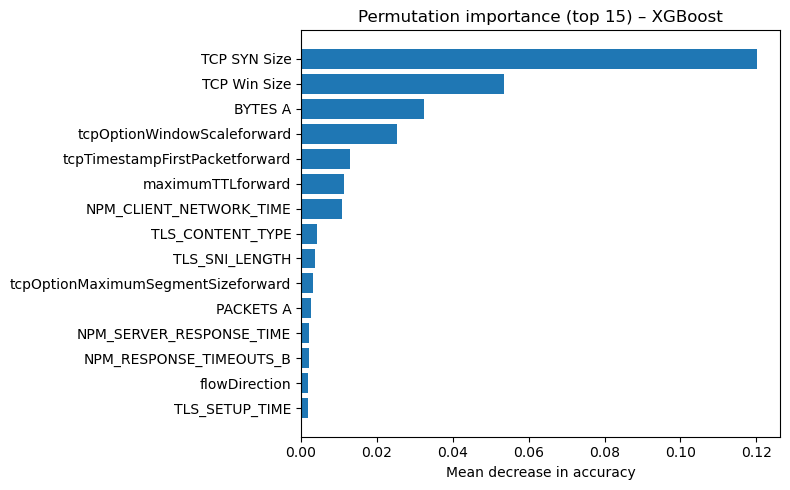


=== Permutation importance: LightGBM ===


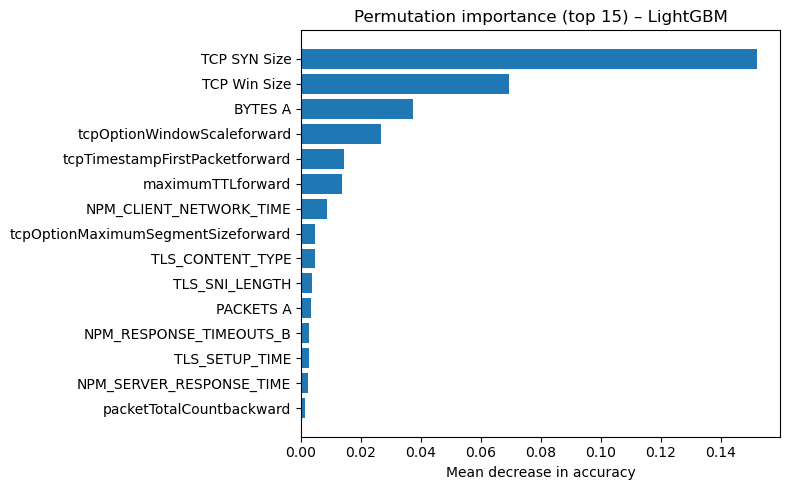


=== Permutation importance: CatBoost ===


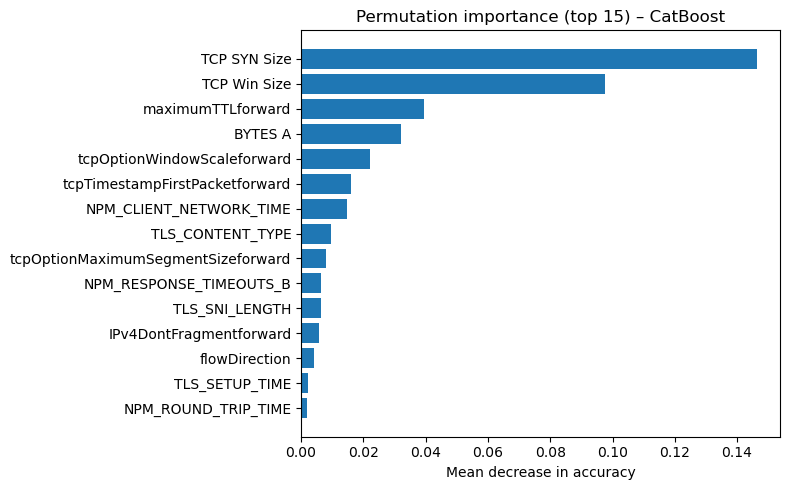


=== Permutation importance: MLP ===


c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


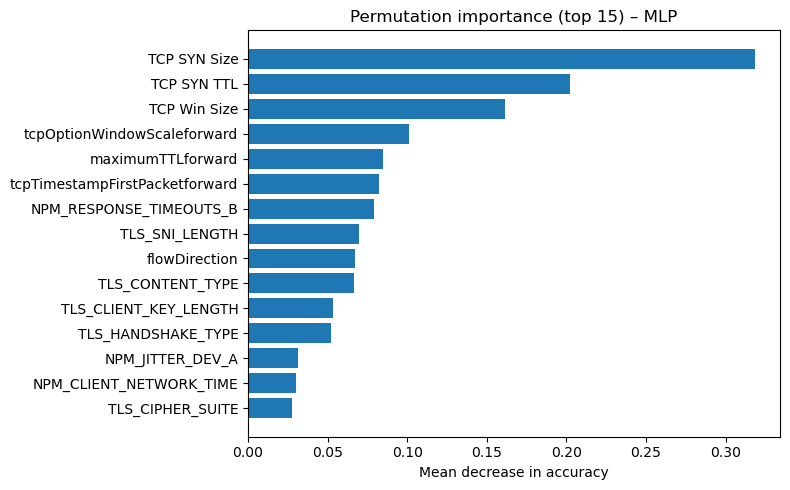

In [22]:
# ===== Permutation importance for all models =====

models_for_perm = {
    "XGBoost":   (xgb_bal,  X_test_imp_df),     # tree models: use unscaled, imputed
    "LightGBM":  (lgbm_bal, X_test_imp_df),
    "CatBoost":  (cat_bal,  X_test_imp_df),
    "MLP":       (mlp_bal,  X_test_scaled_df),  # MLP expects scaled inputs
}

perm_importances = {}  # will hold mean importances for cross-model comparison

for name, (model, X_eval) in models_for_perm.items():
    print(f"\n=== Permutation importance: {name} ===")
    result = permutation_importance(
        model,
        X_eval,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
    )
    imp_mean = result.importances_mean
    perm_importances[name] = imp_mean  # store for later
    
    # Plot top-k features
    k = 15
    idx = np.argsort(imp_mean)[::-1][:k]
    plt.figure(figsize=(8, 5))
    plt.barh(range(k), imp_mean[idx][::-1])
    plt.yticks(range(k), [feature_names[i] for i in idx][::-1])
    plt.xlabel("Mean decrease in accuracy")
    plt.title(f"Permutation importance (top {k}) – {name}")
    plt.tight_layout()
    plt.show()



=== SHAP summary: XGBoost ===


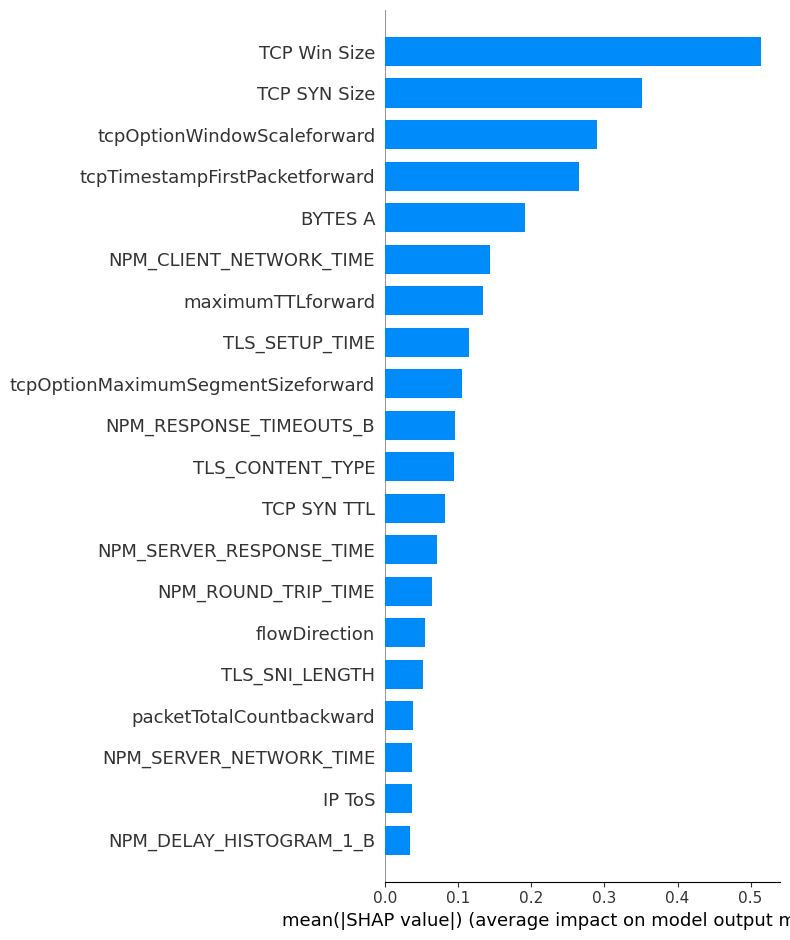

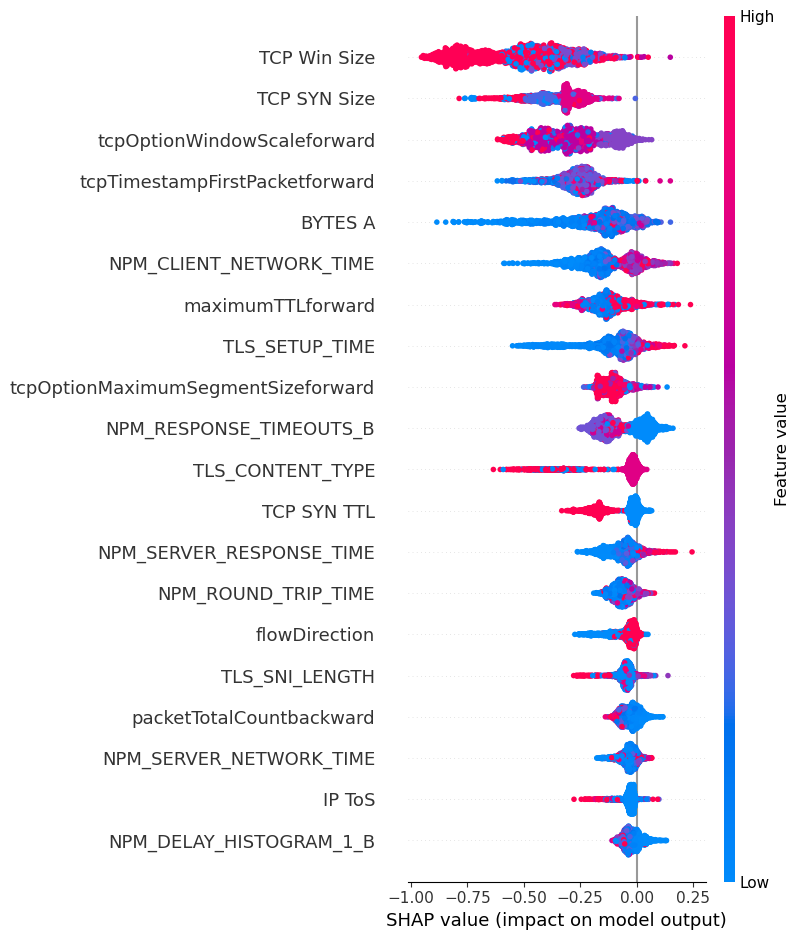


=== SHAP summary: LightGBM ===


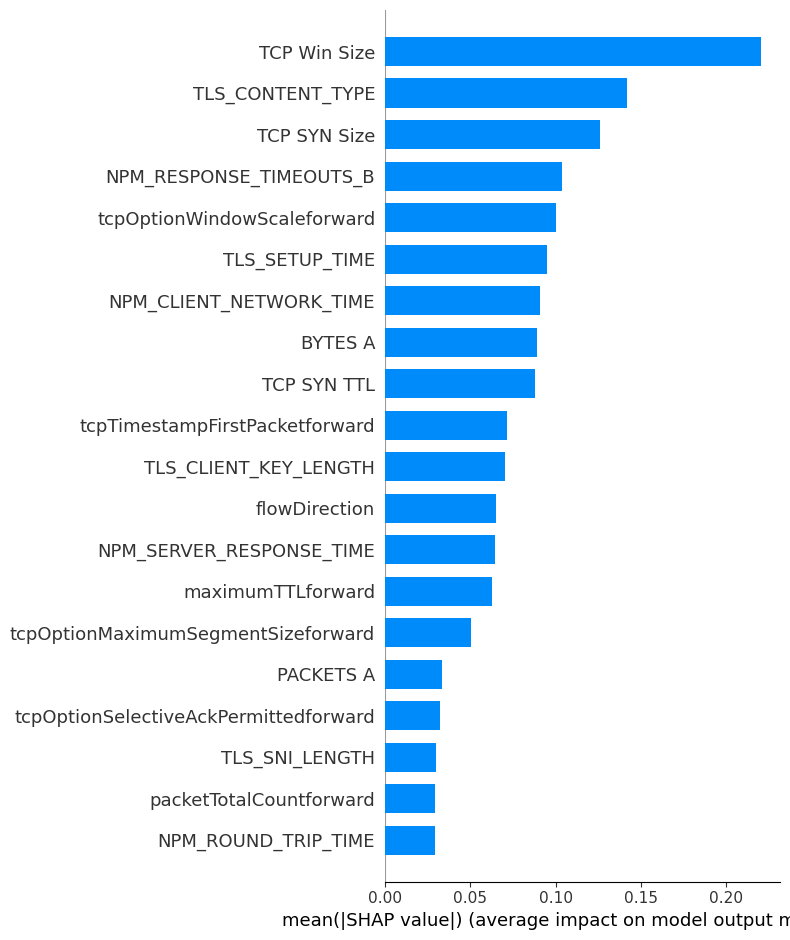

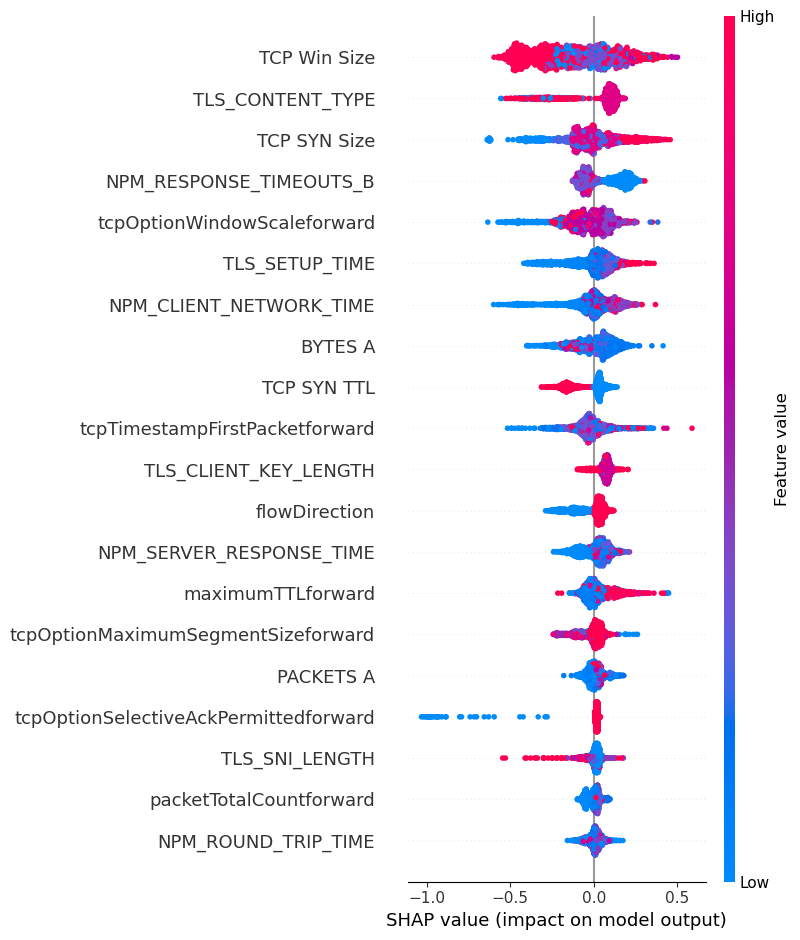

In [23]:
# ===== SHAP analysis for tree models =====

import shap
shap.initjs()

# Use a subset of test data for speed
max_samples = 2000
sample_idx = np.random.choice(X_test_imp_df.index,
                              size=min(max_samples, len(X_test_imp_df)),
                              replace=False)
X_shap = X_test_imp_df.iloc[sample_idx]

tree_models = {
    "XGBoost":  xgb_bal,
    "LightGBM": lgbm_bal,
    #"CatBoost": cat_bal,
}

for name, model in tree_models.items():
    print(f"\n=== SHAP summary: {name} ===")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    # Handle multi-class case: average SHAP across classes
    if isinstance(shap_values, list):
        shap_values_array = np.stack(shap_values, axis=0)   # [n_classes, n_samples, n_features]
        shap_values_mean = np.mean(shap_values_array, axis=0)
    else:
        # shap_values already [n_samples, n_features, (n_classes?)]
        if shap_values.ndim == 3:
            shap_values_mean = np.mean(shap_values, axis=2)
        else:
            shap_values_mean = shap_values

    # Summary bar plot (global importance)
    shap.summary_plot(
        shap_values_mean,
        X_shap,
        feature_names=feature_names,
        plot_type="bar",
        show=True
    )

    # Standard summary (beeswarm) plot
    shap.summary_plot(
        shap_values_mean,
        X_shap,
        feature_names=feature_names,
        show=True
    )


In [26]:
# ===== LIME explainers for all models =====
from lime.lime_tabular import LimeTabularExplainer

# feature_names is the list of numeric feature columns you used for X
feature_names = X.columns.tolist()
class_names = le.classes_

# Wrap train + test matrices as DataFrames for convenience
X_train_bal_df = pd.DataFrame(X_train_bal, columns=feature_names)
X_test_imp_df  = pd.DataFrame(X_test_imp,  columns=feature_names)

# For MLP: scaled versions (same order of features)
X_train_bal_scaled_df = pd.DataFrame(X_train_bal_scaled, columns=feature_names)
X_test_bal_scaled_df  = pd.DataFrame(X_test_bal_scaled,  columns=feature_names)

print("Train (balanced) shape:", X_train_bal_df.shape)
print("Test shape:", X_test_imp_df.shape)

# Explainer for models trained on *unscaled, imputed* features
lime_explainer_unscaled = LimeTabularExplainer(
    training_data=X_train_bal_df.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
)

# Explainer for models trained on *scaled* features (MLP)
lime_explainer_scaled = LimeTabularExplainer(
    training_data=X_train_bal_scaled_df.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
)


Train (balanced) shape: (170110, 43)
Test shape: (21933, 43)


In [27]:
# ===== LIME local explanations for all models =====

def explain_instance_all(idx=0, num_features=10):
    """
    Show LIME explanations for XGBoost, LightGBM, CatBoost, and MLP
    on the same test instance (by index in X_test / y_test).
    """
    print(f"=== LIME explanations for test instance {idx} ===")
    true_label = class_names[y_test[idx]]
    print("True label:", true_label)

    # Unscaled / imputed representation (for tree models)
    x_unscaled_2d = X_test_imp_df.iloc[[idx]].values   # shape (1, n_features)
    x_unscaled_1d = X_test_imp_df.iloc[idx].values     # shape (n_features,)

    # Scaled representation (for MLP)
    x_scaled_2d = X_test_bal_scaled_df.iloc[[idx]].values
    x_scaled_1d = X_test_bal_scaled_df.iloc[idx].values

    # ---------------- XGBoost ----------------
    pred_xgb = class_names[xgb_bal.predict(x_unscaled_2d)[0]]
    print("XGBoost predicted:", pred_xgb)

    exp_xgb = lime_explainer_unscaled.explain_instance(
        data_row=x_unscaled_1d,
        predict_fn=lambda x: xgb_bal.predict_proba(x),
        num_features=num_features,
    )
    fig = exp_xgb.as_pyplot_figure()
    plt.title(f"LIME – XGBoost (instance {idx}, true={true_label}, pred={pred_xgb})")
    plt.tight_layout()
    plt.show()

    # ---------------- LightGBM ----------------
    pred_lgbm = class_names[lgbm_bal.predict(x_unscaled_2d)[0]]
    print("LightGBM predicted:", pred_lgbm)

    exp_lgbm = lime_explainer_unscaled.explain_instance(
        data_row=x_unscaled_1d,
        predict_fn=lambda x: lgbm_bal.predict_proba(x),
        num_features=num_features,
    )
    fig = exp_lgbm.as_pyplot_figure()
    plt.title(f"LIME – LightGBM (instance {idx}, true={true_label}, pred={pred_lgbm})")
    plt.tight_layout()
    plt.show()

    # ---------------- CatBoost ----------------
    pred_cat = class_names[cat_bal.predict(x_unscaled_2d)[0]]
    print("CatBoost predicted:", pred_cat)

    exp_cat = lime_explainer_unscaled.explain_instance(
        data_row=x_unscaled_1d,
        predict_fn=lambda x: cat_bal.predict_proba(x),
        num_features=num_features,
    )
    fig = exp_cat.as_pyplot_figure()
    plt.title(f"LIME – CatBoost (instance {idx}, true={true_label}, pred={pred_cat})")
    plt.tight_layout()
    plt.show()

    # ---------------- MLP (scaled features) ----------------
    pred_mlp = class_names[mlp_bal.predict(x_scaled_2d)[0]]
    print("MLP predicted:", pred_mlp)

    exp_mlp = lime_explainer_scaled.explain_instance(
        data_row=x_scaled_1d,
        predict_fn=lambda x: mlp_bal.predict_proba(x),
        num_features=num_features,
    )
    fig = exp_mlp.as_pyplot_figure()
    plt.title(f"LIME – MLP (instance {idx}, true={true_label}, pred={pred_mlp})")
    plt.tight_layout()
    plt.show()

=== LIME explanations for test instance 0 ===
True label: Windows
XGBoost predicted: Windows


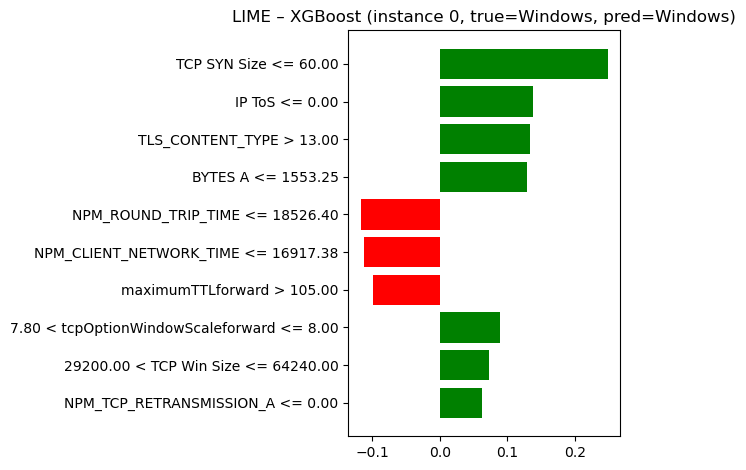

c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Siddhartha\miniconda3\envs\ML\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM predicted: Windows


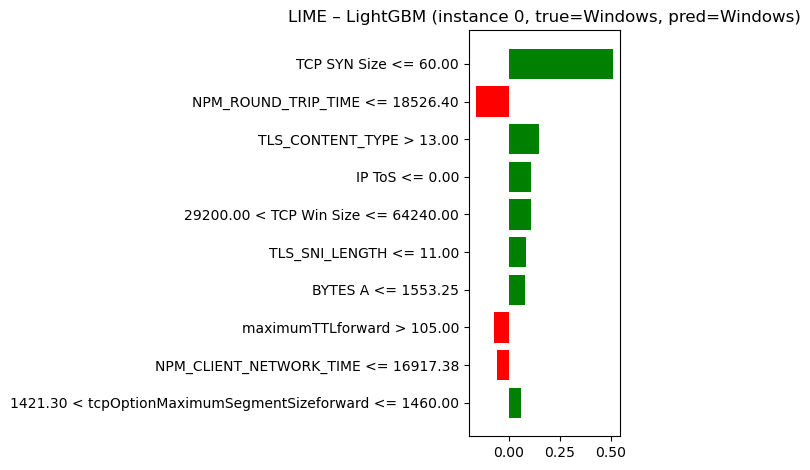

CatBoost predicted: ['Windows']


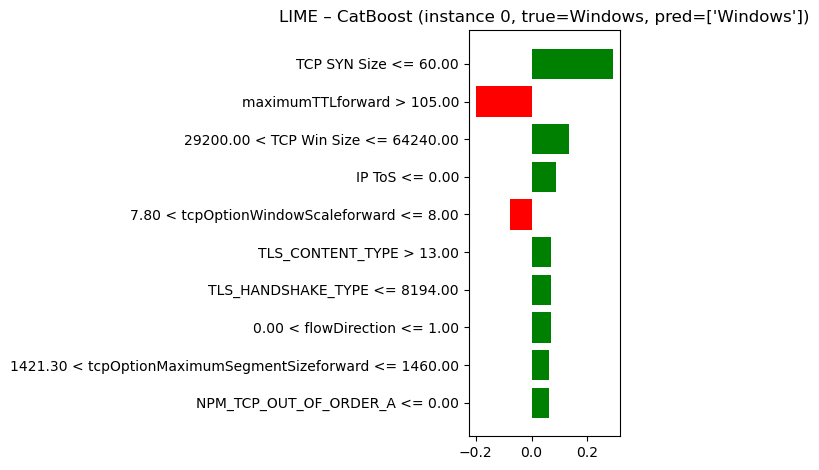

MLP predicted: Windows


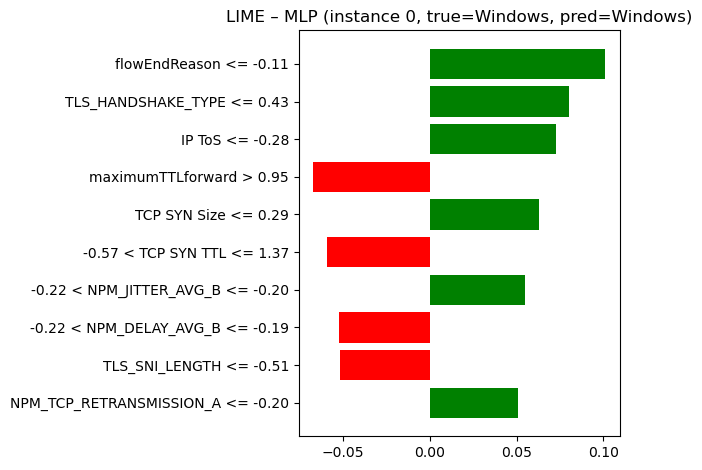

In [28]:
# 1) Single example (e.g. first test sample)
explain_instance_all(idx=0, num_features=10)


Top features by average permutation importance:


,XGBoost,LightGBM,CatBoost,MLP
TCP SYN Size,0.120262,0.152182,0.146464,0.318251
TCP Win Size,0.053568,0.069393,0.097552,0.161601
TCP SYN TTL,0.000378,0.001404,0.000634,0.202508
tcpOptionWindowScaleforward,0.025236,0.026763,0.022154,0.100935
maximumTTLforward,0.011426,0.013514,0.039571,0.084936
tcpTimestampFirstPacketforward,0.013026,0.014280,0.015962,0.082255
BYTES A,0.032426,0.037245,0.032111,0.021620
NPM_RESPONSE_TIMEOUTS_B,0.002033,0.002622,0.006447,0.079027
TLS_CONTENT_TYPE,0.004062,0.004518,0.009643,0.066316
TLS_SNI_LENGTH,0.003547,0.003666,0.006392,0.069544


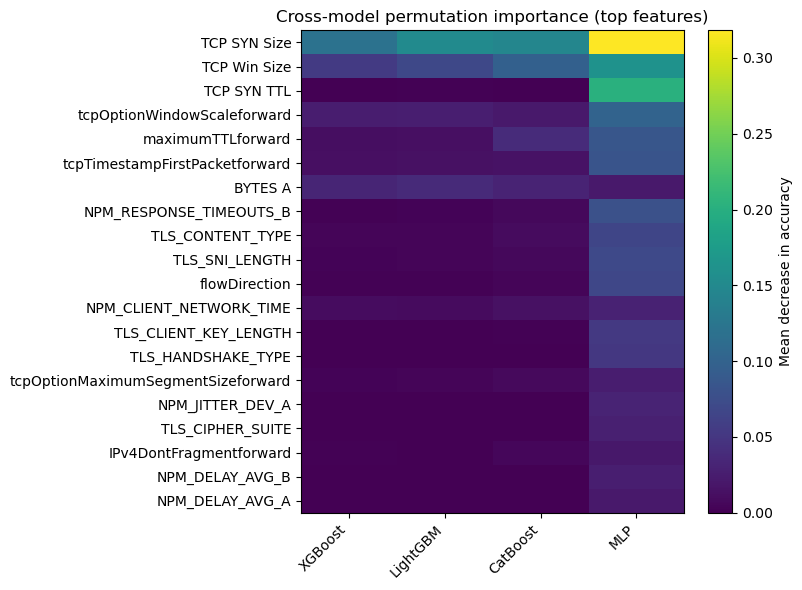

In [25]:
# ===== Cross-model feature importance comparison =====

# Build DataFrame: rows = features, cols = models
imp_df = pd.DataFrame(
    {name: vals for name, vals in perm_importances.items()},
    index=feature_names
)

# Sort by mean importance across models and take top-k for display
k = 20
top_features = imp_df.mean(axis=1).sort_values(ascending=False).head(k).index
imp_top = imp_df.loc[top_features]

print("Top features by average permutation importance:")
display(imp_top)

# Heatmap-style plot (using matplotlib only)
plt.figure(figsize=(8, 6))
plt.imshow(imp_top.values, aspect="auto")
plt.colorbar(label="Mean decrease in accuracy")
plt.xticks(range(len(imp_top.columns)), imp_top.columns, rotation=45, ha="right")
plt.yticks(range(len(imp_top.index)), imp_top.index)
plt.title("Cross-model permutation importance (top features)")
plt.tight_layout()
plt.show()
